# SARIMA

`Seasonal Autoregressive Integrated Moving Average`

---

SARIMA is a time series forecasting model that requires:

    A time-based index – Dispatch_Time is timestamped.
    A numerical variable to forecast – Incident Count per Time Period (aggregated count of incidents over time).
    A clear time frequency – Since timestamps are irregular, I will resample to a consistent interval (hourly).
    Sufficient historical data – Data from 2010-2011.

In [17]:
# Import statements
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [10]:
# Load the dataset
tps_incidents = pd.read_csv('../data/tps_incident_data_2010.csv')
display(tps_incidents)

,Dispatch_Time,ID,Incident_Type,Priority_Number,Units_Arrived_At_Scene,FSA
0,2010-01-01 00:01:36,3061660,Medical,4,2,M5R
1,2010-01-01 00:04:23,3061663,Medical,1,1,M5V
2,2010-01-01 00:05:52,3061664,Medical,5,1,M5N
3,2010-01-01 00:09:53,3061667,Medical,1,1,M4Y
4,2010-01-01 00:10:36,3061668,Medical,1,2,M6K
...,...,...,...,...,...,...
204800,2010-12-31 23:54:16,3364482,Medical,4,1,M5B
204801,2010-12-31 23:54:35,3364481,Medical,4,1,M1H
204802,2010-12-31 23:54:40,3364480,Medical,1,1,M4X
204803,2010-12-31 23:57:24,3364485,Medical,1,1,M6K


## Data Preparation

In [12]:
# Convert Dispatch_Time to a datetime format
tps_incidents["Dispatch_Time"] = pd.to_datetime(tps_incidents["Dispatch_Time"])

# Set the Dispatch_Time column as the index
tps_incidents.set_index("Dispatch_Time", inplace=True)

# Resample the data to an hourly interval and aggregate by count (number of incidents per day)
daily_counts = tps_incidents.resample("D").size()

In [13]:
# Drop any dates in 2011 from daily_counts
daily_counts = daily_counts[daily_counts.index < "2011-01-01"]
print(daily_counts)

Dispatch_Time
2010-01-01    609
2010-01-02    478
2010-01-03    526
2010-01-04    497
2010-01-05    545
             ... 
2010-12-27    616
2010-12-28    620
2010-12-29    605
2010-12-30    631
2010-12-31    646
Freq: D, Length: 365, dtype: int64


## Check for Stationarity using ADF test

In [14]:
# Use the Augmented Dickey-Fuller (ADF) Test to check for stationarity
result = adfuller(daily_counts)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.128541172519295
p-value: 0.7035568733502117


In [15]:
# Since p-value is > 0.05, need to perform differencing to remove trends
daily_counts = daily_counts.diff().dropna()

## Fit the SARIMA Model

---

**Results of model fitting**:
* The final function values (F = 4.8239689679214939 and F = 4.8234143676718073) as well as the statement "CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH" suggests the model converged properly.

In [18]:
# Fit the SARIMA model
sarima_model = sm.tsa.statespace.SARIMAX(daily_counts, 
                                          # ARIMA (p,d,q)
                                          order=(1,1,1),
                                          # Seasonality (P,D,Q,s)
                                          seasonal_order=(1,1,1,7),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
results = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.05305D+00    |proj g|=  2.72942D-01

At iterate    5    f=  5.00107D+00    |proj g|=  5.91933D-02

At iterate   10    f=  4.96502D+00    |proj g|=  2.53368D-01

At iterate   15    f=  4.95440D+00    |proj g|=  2.44680D-02

At iterate   20    f=  4.94538D+00    |proj g|=  1.92382D-01

At iterate   25    f=  4.87402D+00    |proj g|=  3.26757D-01


 This problem is unconstrained.



At iterate   30    f=  4.82499D+00    |proj g|=  7.30634D-02

At iterate   35    f=  4.82397D+00    |proj g|=  3.84725D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     50      1     0     0   3.154D-05   4.824D+00
  F =   4.8239689679214939     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


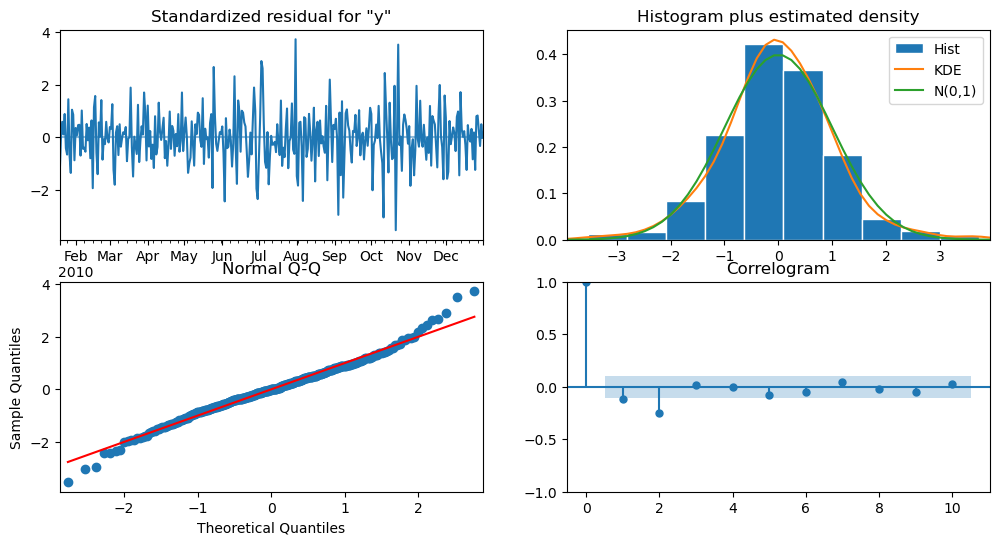

In [19]:
# Plot the model diagnostics looking for:
    # Residual plots - look like white noise
    # Q-Q plot - close to normal distribution
    # Correlogram (ACF of residuals) - not have strong autocorrelation
results.plot_diagnostics(figsize=(12, 6))
plt.show()

## Forecasting

In [20]:
# Forecast the next 30 days
forecast = results.get_forecast(steps=30)
forecast_index = pd.date_range(start=daily_counts.index[-1], periods=30, freq="D")

## SARIMA Plots

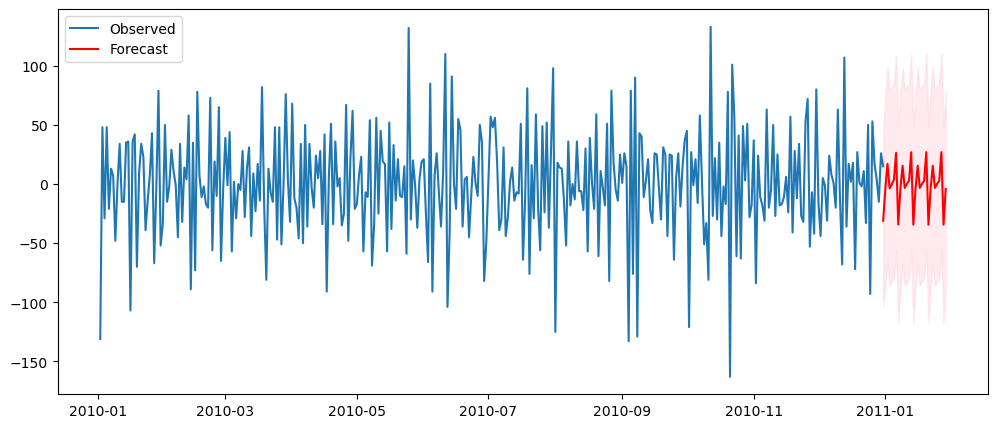

In [26]:
plt.figure(figsize=(12,5))
plt.plot(daily_counts, label='Observed')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='red')
# Confidence intervals
plt.fill_between(forecast_index, 
                 forecast.conf_int()["lower y"], 
                 forecast.conf_int()["upper y"], 
                 color="pink", alpha=0.3)
plt.legend()
plt.savefig('../results/sarima_forecast30.png')
plt.show()

### Overlay Actual Dataset with Forecasting

In [22]:
# Define the cutoff date for training
train_cutoff = "2010-12-01"

# Train SARIMA model on data before December 1, 2010
train_data = daily_counts[:train_cutoff]

# Fit SARIMA model
sarima_overlay_model = sm.tsa.statespace.SARIMAX(train_data, 
                                  # ARIMA (p,d,q)
                                  order=(1,1,1),
                                  # Seasonality (P,D,Q,s) 
                                  seasonal_order=(1,1,1,7), 
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False)
results_overlay = sarima_overlay_model.fit()

# Forecast for December 1 - December 31, 2010
forecast_steps = 30
forecast_overlay = results_overlay.get_forecast(steps=forecast_steps)
forecast_index_overlay = pd.date_range(start=train_cutoff, periods=forecast_steps, freq="D")

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.04319D+00    |proj g|=  2.72499D-01

At iterate    5    f=  4.99173D+00    |proj g|=  5.73215D-02

At iterate   10    f=  4.94561D+00    |proj g|=  1.92728D-02

At iterate   15    f=  4.94531D+00    |proj g|=  4.14063D-02

At iterate   20    f=  4.92872D+00    |proj g|=  2.20463D-01

At iterate   25    f=  4.89997D+00    |proj g|=  2.81883D-01

At iterate   30    f=  4.82365D+00    |proj g|=  2.52541D-02

At iterate   35    f=  4.82341D+00    |proj g|=  8.46915D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

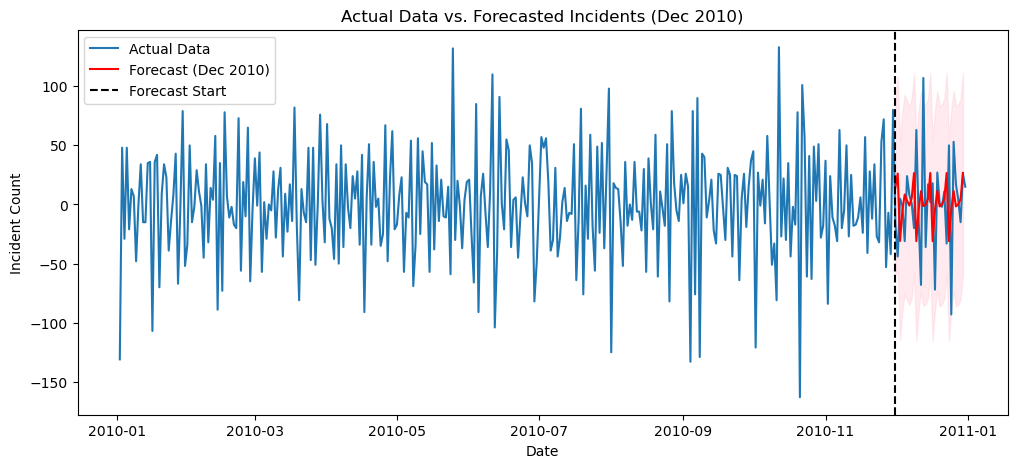

In [25]:
# Plot the actual data
plt.figure(figsize=(12,5))
plt.plot(daily_counts, label='Actual Data')
plt.plot(forecast_index_overlay, forecast_overlay.predicted_mean, label='Forecast (Dec 2010)', color='red')

# Add confidence interval shading
plt.fill_between(forecast_index_overlay, 
                 forecast_overlay.conf_int()['lower y'], 
                 forecast_overlay.conf_int()['upper y'], 
                 color='pink', alpha=0.3)

# Labels and legend
plt.axvline(x=pd.to_datetime(train_cutoff), color='black', linestyle='--', label='Forecast Start')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Incident Count')
plt.title('Actual Data vs. Forecasted Incidents (Dec 2010)')
plt.savefig('../results/sarima_forecast30_including_actual.png')
plt.show()